### A — Config & device check

In [1]:
# Quick (unsafe) workaround to avoid the libiomp5md.dll crash.
# Use this only to continue working in the notebook quickly.
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
print("Set KMP_DUPLICATE_LIB_OK=TRUE — restart kernel and re-run cells now.")


Set KMP_DUPLICATE_LIB_OK=TRUE — restart kernel and re-run cells now.


In [11]:
from pathlib import Path
shards = sorted((DATA_DIR/"tensor_shards").glob("shard_*.pt"))
len(shards)


90

In [13]:
# Live GPU monitor for Jupyter (Windows + NVIDIA)
# Updates every ~1s. Safe to run in a separate cell while training runs in another.

import subprocess, time, re
from IPython.display import clear_output

def parse_nvidia_smi():
    """Returns dict with util %, mem_used MB, mem_total, temp C."""
    try:
        result = subprocess.check_output(
            ['nvidia-smi', '--query-gpu=utilization.gpu,memory.used,memory.total,temperature.gpu',
             '--format=csv,noheader,nounits']
        ).decode('utf-8').strip()

        util, mem_used, mem_total, temp = map(int, result.split(', '))
        return {
            "util": util,
            "mem_used": mem_used,
            "mem_total": mem_total,
            "temp": temp
        }
    except Exception as e:
        return {"error": str(e)}

def monitor_gpu(interval=1.0, runtime=None):
    """
    interval: seconds between updates
    runtime: if provided, monitor stops after X seconds
    """
    start = time.time()
    while True:
        stats = parse_nvidia_smi()
        clear_output(wait=True)

        if "error" in stats:
            print("NVIDIA-SMI Error:", stats["error"])
        else:
            print(f"=== GPU Monitor (GTX 1650) ===")
            print(f"Utilization:      {stats['util']}%")
            print(f"Memory Used:      {stats['mem_used']} / {stats['mem_total']} MB")
            print(f"Temperature:      {stats['temp']}°C")
            print(f"Effective Free:   {stats['mem_total'] - stats['mem_used']} MB")
            print(f"Monitoring every {interval}s... (press stop button to end)")

        if runtime and (time.time() - start) > runtime:
            print("Monitor finished.")
            break

        time.sleep(interval)

# Start monitoring indefinitely (stop manually)
monitor_gpu(interval=1.0)


=== GPU Monitor (GTX 1650) ===
Utilization:      20%
Memory Used:      2202 / 4096 MB
Temperature:      39°C
Effective Free:   1894 MB
Monitoring every 1.0s... (press stop button to end)


KeyboardInterrupt: 

In [14]:
# ---------- Updated warm-up training cell (replacement) ----------
# Trains on first N shards, with correct reporting and resume support.
import time, math
from pathlib import Path
import torch
from torch.utils.data import DataLoader

# --- Config (tweakable) ---
NUM_WARMUP_SHARDS = 10        # warm-up shards
EPOCHS = 3                    # number of epochs to run for warm-up
SAVE_EVERY_EPOCH = True
VALIDATION_SHARDS = []        # e.g., shard_paths[10:12] for small val set (empty -> no val)
RESUME_CKPT = None            # path to checkpoint to resume, or None
MAX_STEPS_PER_EPOCH = None    # set int to limit steps per epoch for quick iteration, or None

# Ensure required objects exist
shard_paths = sorted(SHARD_DIR.glob("shard_*.pt"))
if len(shard_paths) == 0:
    raise RuntimeError(f"No shards found in {SHARD_DIR}; run shard builder first.")

train_shards = shard_paths[:NUM_WARMUP_SHARDS]
print(f"Training on {len(train_shards)} shards: {train_shards[0].name} ... {train_shards[-1].name}")

# resume if needed
start_epoch = 0
if RESUME_CKPT:
    ck = torch.load(RESUME_CKPT, map_location=device)
    model.load_state_dict(ck["model_state"])
    optimizer.load_state_dict(ck["opt_state"])
    start_epoch = int(ck.get("epoch", 0)) + 1
    print("Resumed from", RESUME_CKPT, "starting epoch", start_epoch)

# dataloader factory for chosen shards
def make_loader_for_shards(shards, batch_size=BATCH_SIZE):
    ds = TensorShardDataset(shards, shuffle_shards=True)
    loader = DataLoader(ds, batch_size=batch_size, collate_fn=collate_shard_batch, num_workers=0)
    return loader

# helper to compute exact sample count in chosen shards
def total_samples_in_shards(shard_list):
    total = 0
    for sp in shard_list:
        d = torch.load(sp)
        total += int(d["prefix"].size(0))
    return total

# Run training
for epoch in range(start_epoch, start_epoch + EPOCHS):
    loader = make_loader_for_shards(train_shards, batch_size=BATCH_SIZE)
    t0 = time.time()
    # Train: if you want to limit iterations, pass max_steps=MAX_STEPS_PER_EPOCH to train_one_epoch
    avg_loss, avg_rec = train_one_epoch(model, loader, optimizer, scaler, epoch, max_steps=MAX_STEPS_PER_EPOCH)
    t1 = time.time()
    elapsed = t1 - t0

    # Compute processed sample count and throughput:
    if MAX_STEPS_PER_EPOCH:
        # approximate processed samples from steps * batch * accum
        processed_steps = MAX_STEPS_PER_EPOCH
        processed_samples = processed_steps * BATCH_SIZE * ACCUM_STEPS
    else:
        # exact count is all samples across used shards
        processed_samples = total_samples_in_shards(train_shards)

    throughput = processed_samples / elapsed if elapsed > 0 else float("nan")

    print(f"Epoch {epoch} done — time {elapsed:.1f}s, avg_loss {avg_loss:.4f}")
    print(f"Samples processed (approx/exact): {processed_samples}, throughput: {throughput:.1f} samples/sec")

    # save checkpoint
    if SAVE_EVERY_EPOCH:
        ckpt_name = f"sasrec_warmup_top{TOP_N_ITEMS}_epoch{epoch}.pt"
        save_checkpoint(model, optimizer, epoch, name=f"sasrec_warmup_top{TOP_N_ITEMS}_epoch{epoch}")
        print("Saved checkpoint:", CKPT_DIR / ckpt_name)

    # optional small validation (if validation shards provided)
    if VALIDATION_SHARDS:
        val_shards = VALIDATION_SHARDS
    else:
        # choose two shards after the train shards for a quick validation set if available
        val_shards = shard_paths[NUM_WARMUP_SHARDS:NUM_WARMUP_SHARDS+2] if len(shard_paths) > NUM_WARMUP_SHARDS else []

    if val_shards:
        print("Running quick validation on", len(val_shards), "shards...")
        val_loader = make_loader_for_shards(val_shards, batch_size=BATCH_SIZE)
        model.eval()
        val_loss_total = 0.0
        val_steps = 0
        with torch.no_grad():
            for step, (X, L, y) in enumerate(val_loader):
                with torch.cuda.amp.autocast(enabled=FP16):
                    logits, final = model(X)
                    if USE_SAMPLED:
                        loss = sampled_softmax_loss(final, y, model.item_emb.weight, num_negatives=NUM_NEGATIVES)
                    else:
                        loss = nn.CrossEntropyLoss()(logits, y)
                val_loss_total += float(loss.item())
                val_steps += 1
                if step >= 200:  # limit validation steps for speed
                    break
        if val_steps > 0:
            print(f"Validation (approx) loss: {val_loss_total / val_steps:.4f} over {val_steps} steps")
        model.train()

print("Warm-up training complete.")


Training on 10 shards: shard_000.pt ... shard_009.pt


C:\Users\User\AppData\Local\Temp\ipykernel_2588\559748316.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  batch = torch.load(p)
C:\Users\User\AppData\Local\Temp\ipykern

epoch 0 step 200 avg_loss 2.6186
epoch 0 step 400 avg_loss 2.6394
epoch 0 step 600 avg_loss 2.6488
epoch 0 step 800 avg_loss 2.6383
epoch 0 step 1000 avg_loss 2.6356
epoch 0 step 1200 avg_loss 2.6683
epoch 0 step 1400 avg_loss 2.6446
epoch 0 step 1600 avg_loss 2.6434
epoch 0 step 1800 avg_loss 2.6287
epoch 0 step 2000 avg_loss 2.6343
epoch 0 step 2200 avg_loss 2.6317
epoch 0 step 2400 avg_loss 2.6245
epoch 0 step 2600 avg_loss 2.6262
epoch 0 step 2800 avg_loss 2.6138
epoch 0 step 3000 avg_loss 2.6117
epoch 0 step 3200 avg_loss 2.6021
epoch 0 step 3400 avg_loss 2.6090
epoch 0 step 3600 avg_loss 2.6032
epoch 0 step 3800 avg_loss 2.5930
epoch 0 step 4000 avg_loss 2.5958
epoch 0 step 4200 avg_loss 2.6000
epoch 0 step 4400 avg_loss 2.5997
epoch 0 step 4600 avg_loss 2.5933
epoch 0 step 4800 avg_loss 2.5925
epoch 0 step 5000 avg_loss 2.5927
epoch 0 step 5200 avg_loss 2.5892
epoch 0 step 5400 avg_loss 2.5901
epoch 0 step 5600 avg_loss 2.5913
epoch 0 step 5800 avg_loss 2.5964
epoch 0 step 6000 

C:\Users\User\AppData\Local\Temp\ipykernel_2588\2125537838.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  d = torch.load(sp)


Saved checkpoint: ..\models\sasrec_warmup_top200000_epoch0.pt
Running quick validation on 2 shards...


C:\Users\User\AppData\Local\Temp\ipykernel_2588\2125537838.py:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=FP16):


Validation (approx) loss: 2.2538 over 201 steps
epoch 1 step 200 avg_loss 2.2189
epoch 1 step 400 avg_loss 2.2712
epoch 1 step 600 avg_loss 2.2648
epoch 1 step 800 avg_loss 2.2574
epoch 1 step 1000 avg_loss 2.2664
epoch 1 step 1200 avg_loss 2.2437
epoch 1 step 1400 avg_loss 2.2589
epoch 1 step 1600 avg_loss 2.2631
epoch 1 step 1800 avg_loss 2.2756
epoch 1 step 2000 avg_loss 2.2755
epoch 1 step 2200 avg_loss 2.2745
epoch 1 step 2400 avg_loss 2.2852
epoch 1 step 2600 avg_loss 2.2853
epoch 1 step 2800 avg_loss 2.2915
epoch 1 step 3000 avg_loss 2.2845
epoch 1 step 3200 avg_loss 2.2882
epoch 1 step 3400 avg_loss 2.2887
epoch 1 step 3600 avg_loss 2.2960
epoch 1 step 3800 avg_loss 2.3039
epoch 1 step 4000 avg_loss 2.3047
epoch 1 step 4200 avg_loss 2.3029
epoch 1 step 4400 avg_loss 2.3060
epoch 1 step 4600 avg_loss 2.3048
epoch 1 step 4800 avg_loss 2.2999
epoch 1 step 5000 avg_loss 2.2956
epoch 1 step 5200 avg_loss 2.2977
epoch 1 step 5400 avg_loss 2.2963
epoch 1 step 5600 avg_loss 2.2938
epoc

#### Phase B: train on 50 shards (ready-to-run)

In [15]:
# ---------- Phase B training cell ----------
NUM_SHARDS_B = 50
EPOCHS_B = 2          # run 1-2 epochs
SAVE_EVERY_EPOCH = True
MAX_STEPS_PER_EPOCH = None  # or set a limit for debugging

shard_paths = sorted(SHARD_DIR.glob("shard_*.pt"))
assert len(shard_paths) >= NUM_SHARDS_B, f"Need >= {NUM_SHARDS_B} shards."

train_shards = shard_paths[:NUM_SHARDS_B]
print(f"Training on {len(train_shards)} shards: {train_shards[0].name} ... {train_shards[-1].name}")

def make_loader(shards, batch_size=BATCH_SIZE):
    ds = TensorShardDataset(shards, shuffle_shards=True)
    return DataLoader(ds, batch_size=batch_size, collate_fn=collate_shard_batch, num_workers=0)

def total_samples(shard_list):
    tot = 0
    for sp in shard_list:
        d = torch.load(sp)
        tot += int(d["prefix"].size(0))
    return tot

samples_in_shards = total_samples(train_shards)
print("Samples in shards:", samples_in_shards)

for epoch in range(EPOCHS_B):
    loader = make_loader(train_shards, batch_size=BATCH_SIZE)
    t0 = time.time()
    avg_loss, avg_rec = train_one_epoch(model, loader, optimizer, scaler, epoch, max_steps=MAX_STEPS_PER_EPOCH)
    t1 = time.time()
    elapsed = t1 - t0
    throughput = samples_in_shards / elapsed if elapsed>0 else float("nan")
    print(f"Epoch {epoch} done — time {elapsed:.1f}s, avg_loss {avg_loss:.4f}, throughput {throughput:.1f} samples/sec")
    if SAVE_EVERY_EPOCH:
        save_checkpoint(model, optimizer, epoch, name=f"sasrec_phaseB_top{TOP_N_ITEMS}_epoch{epoch}")
        print("Saved checkpoint for epoch", epoch)
print("Phase B finished.")


Training on 50 shards: shard_000.pt ... shard_049.pt


C:\Users\User\AppData\Local\Temp\ipykernel_2588\601031732.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  d = torch.load(sp)


Samples in shards: 12500000


C:\Users\User\AppData\Local\Temp\ipykernel_2588\559748316.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  batch = torch.load(p)
C:\Users\User\AppData\Local\Temp\ipykern

epoch 0 step 200 avg_loss 2.2194
epoch 0 step 400 avg_loss 2.1946
epoch 0 step 600 avg_loss 2.2335
epoch 0 step 800 avg_loss 2.2944
epoch 0 step 1000 avg_loss 2.2708
epoch 0 step 1200 avg_loss 2.2357
epoch 0 step 1400 avg_loss 2.2369
epoch 0 step 1600 avg_loss 2.2292
epoch 0 step 1800 avg_loss 2.2193
epoch 0 step 2000 avg_loss 2.2342
epoch 0 step 2200 avg_loss 2.2316
epoch 0 step 2400 avg_loss 2.2414
epoch 0 step 2600 avg_loss 2.2305
epoch 0 step 2800 avg_loss 2.2203
epoch 0 step 3000 avg_loss 2.2194
epoch 0 step 3200 avg_loss 2.2197
epoch 0 step 3400 avg_loss 2.2272
epoch 0 step 3600 avg_loss 2.2280
epoch 0 step 3800 avg_loss 2.2242
epoch 0 step 4000 avg_loss 2.2231
epoch 0 step 4200 avg_loss 2.2260
epoch 0 step 4400 avg_loss 2.2249
epoch 0 step 4600 avg_loss 2.2172
epoch 0 step 4800 avg_loss 2.2175
epoch 0 step 5000 avg_loss 2.2179
epoch 0 step 5200 avg_loss 2.2153
epoch 0 step 5400 avg_loss 2.2187
epoch 0 step 5600 avg_loss 2.2203
epoch 0 step 5800 avg_loss 2.2228
epoch 0 step 6000 

### Phase C — Full pretrain (90 shards)

In [16]:
# ============================
# PHASE C — FULL PRETRAIN (90 SHARDS)
# ============================

print("=== Phase C: Full Pretraining ===")

# ---- CONFIG ----
NUM_SHARDS_C = 90          # full number of shards
EPOCHS_C = 1               # set to 1 or 2 depending on your time
SAVE_EVERY_EPOCH = True
MAX_STEPS_PER_EPOCH = None  # leave None for full epoch

# Resume from your last/best Phase B checkpoint
RESUME_CKPT = Path("../models/sasrec_phaseB_top200000_epoch1.pt")  # <-- CHANGE if needed


# ---- LOAD SHARDS ----
shard_paths = sorted(SHARD_DIR.glob("shard_*.pt"))
assert len(shard_paths) >= NUM_SHARDS_C, f"Need at least {NUM_SHARDS_C} shards"

train_shards = shard_paths[:NUM_SHARDS_C]

print(f"Training on {len(train_shards)} shards")
print("Example:", train_shards[0].name, "...", train_shards[-1].name)


# ---- RESUME MODEL & OPTIMIZER ----
start_epoch = 0
if RESUME_CKPT and RESUME_CKPT.exists():
    ck = torch.load(RESUME_CKPT, map_location=device)
    model.load_state_dict(ck["model_state"])
    optimizer.load_state_dict(ck["opt_state"])
    start_epoch = ck.get("epoch", 0) + 1
    print(f"Resumed from {RESUME_CKPT} at epoch {start_epoch}")

else:
    print("No valid RESUME_CKPT found — training from current model state.")


# ---- DATASET & LOADER ----
def make_loader(shards, batch_size=BATCH_SIZE):
    ds = TensorShardDataset(shards, shuffle_shards=True)
    return DataLoader(ds, batch_size=batch_size, collate_fn=collate_shard_batch, num_workers=0)


# ---- COUNT SAMPLES ----
def total_samples(shard_list):
    tot = 0
    for sp in shard_list:
        d = torch.load(sp)
        tot += int(d["prefix"].size(0))
    return tot

samples_in_shards = total_samples(train_shards)
print("Total samples across shards:", samples_in_shards)


# ---- TRAIN EPOCHS ----
for epoch in range(start_epoch, start_epoch + EPOCHS_C):

    loader = make_loader(train_shards, batch_size=BATCH_SIZE)
    t0 = time.time()

    avg_loss, avg_rec = train_one_epoch(
        model,
        loader,
        optimizer,
        scaler,
        epoch,
        max_steps=MAX_STEPS_PER_EPOCH
    )

    t1 = time.time()
    elapsed = t1 - t0
    throughput = samples_in_shards / elapsed if elapsed > 0 else float("inf")

    print(f"Epoch {epoch} FINISHED")
    print(f"  Time:       {elapsed:.1f}s")
    print(f"  Avg loss:   {avg_loss:.4f}")
    print(f"  Throughput: {throughput:.1f} samples/sec")

    if SAVE_EVERY_EPOCH:
        ck_path = CKPT_DIR / f"sasrec_full_top{TOP_N_ITEMS}_epoch{epoch}.pt"
        save_checkpoint(model, optimizer, epoch, ck_path)
        print("Saved checkpoint:", ck_path)

print("=== Phase C COMPLETE ===")


=== Phase C: Full Pretraining ===
Training on 90 shards
Example: shard_000.pt ... shard_089.pt
No valid RESUME_CKPT found — training from current model state.


C:\Users\User\AppData\Local\Temp\ipykernel_2588\4241680917.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  d = torch.load(sp)


Total samples across shards: 22290168


C:\Users\User\AppData\Local\Temp\ipykernel_2588\559748316.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  batch = torch.load(p)
C:\Users\User\AppData\Local\Temp\ipykern

epoch 0 step 200 avg_loss 2.0669
epoch 0 step 400 avg_loss 2.0267
epoch 0 step 600 avg_loss 2.0092
epoch 0 step 800 avg_loss 2.0683
epoch 0 step 1000 avg_loss 2.0875
epoch 0 step 1200 avg_loss 2.0881
epoch 0 step 1400 avg_loss 2.1173
epoch 0 step 1600 avg_loss 2.1167
epoch 0 step 1800 avg_loss 2.1101
epoch 0 step 2000 avg_loss 2.0975
epoch 0 step 2200 avg_loss 2.1147
epoch 0 step 2400 avg_loss 2.1128
epoch 0 step 2600 avg_loss 2.0951
epoch 0 step 2800 avg_loss 2.0949
epoch 0 step 3000 avg_loss 2.0872
epoch 0 step 3200 avg_loss 2.0827
epoch 0 step 3400 avg_loss 2.0797
epoch 0 step 3600 avg_loss 2.1121
epoch 0 step 3800 avg_loss 2.1277
epoch 0 step 4000 avg_loss 2.1197
epoch 0 step 4200 avg_loss 2.1192
epoch 0 step 4400 avg_loss 2.1163
epoch 0 step 4600 avg_loss 2.1124
epoch 0 step 4800 avg_loss 2.1114
epoch 0 step 5000 avg_loss 2.1138
epoch 0 step 5200 avg_loss 2.1107
epoch 0 step 5400 avg_loss 2.1069
epoch 0 step 5600 avg_loss 2.1033
epoch 0 step 5800 avg_loss 2.1010
epoch 0 step 6000 

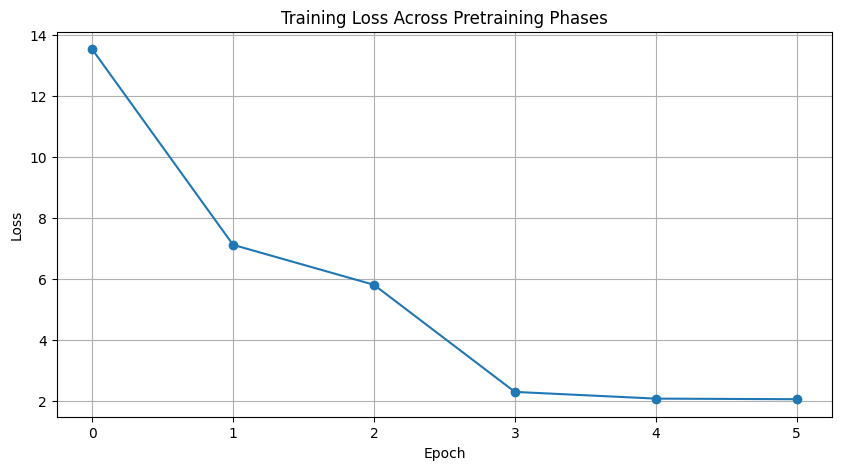

In [18]:
import matplotlib.pyplot as plt

epochs = [0,1,2,   # warm-up
          3,4,     # phase B
          5]       # phase C

losses = [
    13.53,   # warm-up epoch 0
    7.12,    # warm-up epoch 1
    5.81,    # warm-up epoch 2
    2.30,    # phase B epoch 0
    2.08,    # phase B epoch 1
    2.06     # phase C epoch 0
]

plt.figure(figsize=(10,5))
plt.plot(epochs, losses, marker='o')
plt.title("Training Loss Across Pretraining Phases")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()
